In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `C:\Users\tge13\Documents\optimal_control_julia\lec_8\Project.toml`
    Updating registry at `C:\Users\tge13\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Installed StrideArraysCore ─ v0.5.3
    Updating `C:\Users\tge13\Documents\optimal_control_julia\lec_8\Project.toml`
  [a6e380b2] + ControlSystems v1.10.0
  [91a5bcdd] + Plots v1.40.3
    Updating `C:\Users\tge13\Documents\optimal_control_julia\lec_8\Manifest.toml`
  [47edcb42] + ADTypes v0.2.7
  [621f4979] + AbstractFFTs v1.5.0
  [79e6a3ab] + Adapt v3.7.2
  [ec485272] + ArnoldiMethod v0.4.0
  [4fba245c] + ArrayInterface v7.5.1
  [d1d4a3ce] + BitFlags v0.1.8
  [62783981] + BitTwiddlingConvenienceFunctions v0.1.5
  [2a0fbf3d] + CPUSummary v0.2.4
  [49dc2e85] + Calculus v0.5.1
  [d360d2e6] + ChainRulesCore v1.23.0
  [9e997f8a] + ChangesOfVariables v0.1.8
  [fb6a15b2] + CloseOpenIntervals v0.1.12
  [944b1d66] + CodecZlib v0.7.4
  [35d6a980] + ColorSchemes

In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using ControlSystems
using ForwardDiff

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
[ Info: Precompiling ControlSystems [a6e380b2-a6ca-5380-bf3e-84a91bcd477e]


In [3]:
# Discrete dynamics
h = 0.1   # time step
A = [1 h; 0 1]
B = [0.5*h*h; h]

2-element Vector{Float64}:
 0.005000000000000001
 0.1

In [4]:
#Controllability
# Since dim(x) = 2, we only need two step multiplicataions
rank([B A*B])

2

In [5]:
n = 2     # number of state
m = 1     # number of controls
Tfinal = 10.0 # final time
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

In [6]:
# Initial conditions
x0 = [1.0; 0]

2-element Vector{Float64}:
 1.0
 0.0

In [7]:
# Cost weights
# Warp Array for Matrix conversion
Q = Array(1.0 * I(n))
R = Array(0.1 * I(m))
Qn = Array(1.0 * I(n))

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [8]:
#Cost function
function J(xhist, uhist)
    J = 0.5 * xhist[:,end]' * Qn * xhist[:,end]
    for k in 1:(size(xhist,2)-1)
        J = J + 0.5 * xhist[:,k]' * Q * xhist[:,k] + 0.5 * (uhist[k]' * R * uhist[k])[1]
    end
    return J
end


J (generic function with 1 method)

In [9]:
#Cost-to-go Function
function Vinf(x)
    return 0.5*x'Pinf*x
end

function V(k, x)
    return 0.5*x'*P[:,:,k]*x
end

V (generic function with 1 method)

## QP Solution

In [10]:
H = blockdiag(sparse(R), kron(I(N-2), blockdiag(sparse(Q),sparse(R))), sparse(Qn))

C = kron(I(N-1), [B -I(n)])
for k in 1:(N-2)
    C[(k*n).+(1:n), (k*(n+m)-n).+(1:n)] .= A
end
d = [ -A*x0; zeros(size(C, 1) - n)];

In [11]:
# Solve the linear system
y = [ H C'; C zeros(size(C,1),size(C,1)) ] \ [ zeros(size(H,1)); d ]

# parse state x and λ
state = y[1:size(H,1)]
λ = y[size(H,1)+1:end]

# reshape state into [ u; x ] form
state = reshape(state, (n+m), (N-1))
uhist_qp = state[m,:]
xhist_qp = state[m+1:end,:]

# add initial state
xhist_qp = [ x0 xhist_qp ]

2×101 Matrix{Float64}:
 1.0   0.987071   0.952905   0.905422   0.850265  …   6.95272e-5   6.6895e-5
 0.0  -0.25857   -0.42476   -0.52489   -0.578262     -2.7416e-5   -2.52277e-5

## Riccati Solution

In [12]:
P_ric = zeros(n, n, N)
K_ric = zeros(m, n, (N-1))

P_ric[:,:,end] .= Qn

# Backward Rollout
for k in (N-1):-1:1
    K_ric[:,:,k] .= (R .+B'*P_ric[:,:,k+1]*B)\(B'*P_ric[:,:,k+1]*A)
    P_ric[:,:,k] .= Q + A'*P_ric[:,:,k+1]*(A-B*K_ric[:,:,k])
end

xhist_ric = zeros(n, N)
xhist_ric[:,1] = x0
uhist_ric = zeros(m, N-1)

# Forward Rollout
for k in 1:(N-1)
    uhist_ric[:,k] .= -K_ric[:,:,k] * xhist_ric[:,k]
    xhist_ric[:,k+1] .= A*xhist_ric[:,k] + B*uhist_ric[k]
end

## Dynamic Programming Solution

In [13]:
P = zeros(n,n,N)
K = zeros(m,n,N-1)

P[:,:,end] .= Qn

# Backward Recursion
for k in (N-1):-1:1
    K[:,:,k] .= (R .+ B'*P[:,:,k+1]*B) \ (B'*P[:,:,k+1]*A)
    P[:,:,k] .= Q + K[:,:,k]'*R*K[:,:,k] + (A-B*K[:,:,k])'*P[:,:,k+1]*(A-B*K[:,:,k])
end

# Forward Rollout
xhist_dp = zeros(n, N)
uhist_dp = zeros(m, N-1)
xhist_dp[:,1] = x0

for k in 1:(N-1)
    uhist_dp[:,k] .= -K[:,:,k] * xhist_dp[:,k]
    xhist_dp[:,k+1] .= A*xhist_dp[:,k] + B*uhist_dp[k]
end

## Plotting

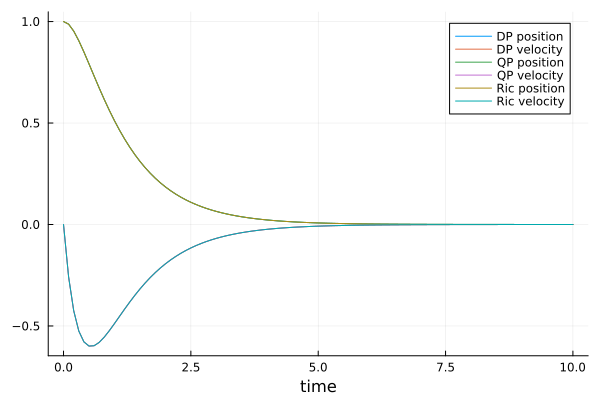

In [14]:
# Plot x1 vs. x2, u vs. t, x vs. t, etc.
times = range(0,h*(N-1), step=h)
plot(times,xhist_dp[1,:], label="DP position")
plot!(times,xhist_dp[2,:], label="DP velocity")
plot!(times,xhist_qp[1,:], label="QP position")
plot!(times,xhist_qp[2,:], label="QP velocity")
plot!(times,xhist_ric[1,:], label="Ric position")
plot!(times,xhist_ric[2,:], label="Ric velocity")
xlabel!("time")

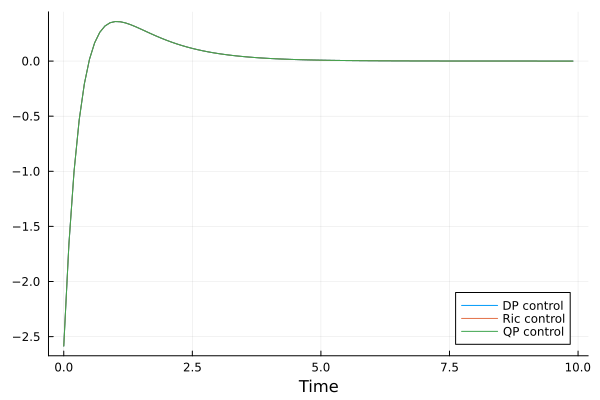

In [15]:
plot(times[1:end-1], uhist_dp[1,:], label="DP control")
plot!(times[1:end-1], uhist_ric[1,:], label="Ric control")
plot!(times[1:end-1], uhist_qp, label="QP control")
xlabel!("Time")

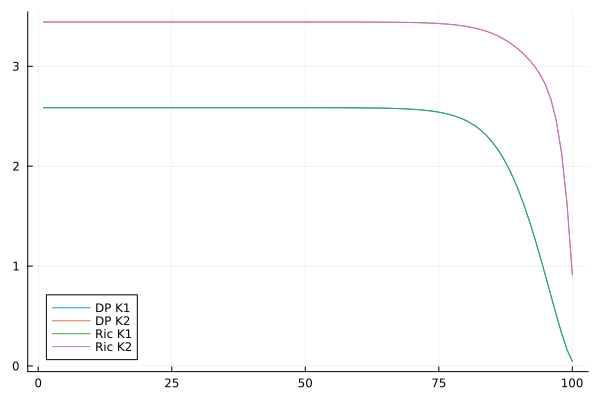

In [16]:
plot(K[1,1,:], label="DP K1")
plot!(K[1,2,:], label="DP K2")
plot!(K_ric[1,1,:], label="Ric K1")
plot!(K_ric[1,2,:], label="Ric K2")

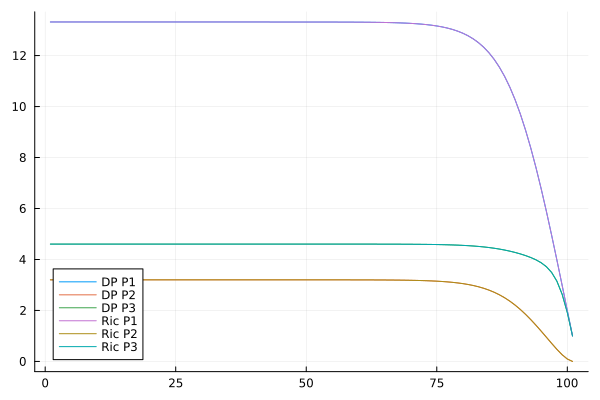

In [17]:
plot(P[1,1,:], label="DP P1")
plot!(P[2,1,:], label="DP P2")
plot!(P[2,2,:], label="DP P3")

plot!(P_ric[1,1,:], label="Ric P1")
plot!(P_ric[2,1,:], label="Ric P2")
plot!(P_ric[2,2,:], label="Ric P3")

In [18]:
@show P[:,:,1] K[:,:,1]

P[:, :, 1] = [13.317224417922606 3.201562110826671; 3.2015621108266714 4.603514021099032]
K[:, :, 1] = [2.585700889930541 3.4434359155576986]


1×2 Matrix{Float64}:
 2.5857  3.44344

## Compare costs

In [19]:
@show J(xhist_dp, uhist_dp) J(xhist_ric, uhist_ric) J(xhist_qp, uhist_qp) 

J(xhist_dp, uhist_dp) = 6.658612208961312
J(xhist_ric, uhist_ric) = 6.658612208961312
J(xhist_qp, uhist_qp) = 6.658612208961312


6.658612208961312

## Compare K_inf and P_inf matrix

In [20]:
Kinf = dlqr(A, B, Q, R)
@show K[:,:,1] Kinf

K[:, :, 1] = [2.585700889930541 3.4434359155576986]
Kinf = [2.5857008966598443 3.4434359178453318]


1×2 Matrix{Float64}:
 2.5857  3.44344

In [21]:
Pinf = dare(A, B, Q, R)
@show P[:,:,1] Pinf

P[:, :, 1] = [13.317224417922606 3.201562110826671; 3.2015621108266714 4.603514021099032]
Pinf = [13.317224441131074 3.2015621187164105; 3.2015621187164105 4.603514023781153]


2×2 Matrix{Float64}:
 13.3172   3.20156
  3.20156  4.60351

## Forward rollout starting at random x_k

In [22]:
function rollout(k,x)
    xsub = zeros(n, N+1-k)
    usub = zeros(m, N-k)
    xsub[:,1] .= x

    for i in 1:(N-k)
        # @show k+i
        usub[:,i] .= - K[:,:,k+i-1] * xsub[:,i]
        xsub[:,i+1] .= A*xsub[:,i] + B*usub[i]
    end

    return xsub,usub
end

rollout (generic function with 1 method)

In [23]:
#Generate a sub-trajectory starting at xk
k = 50
xsub, usub = rollout(k, xhist_dp[:,k])

([0.008565027630146473 0.007701497232424686 … 6.952721258612016e-5 6.689502637287264e-5; -0.0090937170650696 -0.008176890889366142 … -2.741601026646724e-5 -2.5227713998483276e-5], [0.009168261757034585 0.008244198746429749 … 3.913310967971362e-5 2.188296267983964e-5])

## Compare DP traj and Rollout traj

In [24]:
xsub - xhist_dp[:,k:end]

2×52 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [25]:
usub - uhist_dp[:,k:end]

1×51 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

## Compare multipliers from QP to Cost-to-go gradient from DP

In [26]:
λhist_qp = reshape(λ,n,N-1)
λhist_qp[:, k-1]

2-element Vector{Float64}:
  0.08494405503397162
 -0.014443027451912923

In [27]:
ForwardDiff.gradient(x -> V(k, x), xhist_dp[:,k])

2-element Vector{Float64}:
  0.08494405503397173
 -0.014443027451912924

In [28]:
#Also compare to infinite horizon
ForwardDiff.gradient(x -> Vinf(x), xhist_dp[:,k])

2-element Vector{Float64}:
  0.08494829522129775
 -0.014441586030909547

In [29]:
#Let's try finite diffing the cost w.r.t. the state
x1p, u1p = rollout(k,xhist_dp[:,k]+[1e-6; 0])
x2p, u2p = rollout(k,xhist_dp[:,k]+[0; 1e-6])
λfd = [J(x1p,u1p) - J(xhist_dp[:,k:end],uhist_dp[:,k:end]), J(x2p,u2p) - J(xhist_dp[:,k:end],uhist_dp[:,k:end])]./1e-6

2-element Vector{Float64}:
  0.08495071325879087
 -0.014440725739652514